In [26]:
import sys
#pandas==1.0.5
modules=['pandas','mlflow','numpy==1.16','matplotlib']
for m in modules:
    if m not in sys.modules:
        !pip install $m
import pandas as pd
import pyspark
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [27]:
df = pd.read_csv('https://query.data.world/s/6wrcffbc7gqibo343gm5mwq5sa27ff', na_values=['?']).fillna(0)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,1/1/07,0:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0
1,1/1/07,0:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0
2,1/1/07,0:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0
3,1/1/07,0:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0
4,1/1/07,0:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0


In [28]:
# creo una finta colonna Energy_Consumed sulla base della quale oriento la mia predizione, perché nel task attuale
# non viene fornita una variabile su cui fare la predizione, poco male, la creiamo. Alla fine
# e ciò che importa è la data provenance
df['Energy_Consumed'] = df['Global_active_power']*1000/60 - df['Sub_metering_1'] - df['Sub_metering_2'] - df['Sub_metering_3']

In [29]:
#vediamo come sono correlate le feature
data_corr = df.corr()
def _color_red_or_green(val):
    color=''
    if val < -0.4 and val>-1:
        color = 'red' 
    elif val>0.4 and val<0.9:
        color='green'
    elif val>0.4 and val<1:
        color='orange'
    return 'color: %s' % color
data_corr.style.applymap(_color_red_or_green)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Energy_Consumed
Global_active_power,1.000000,0.290249,0.070646,0.998998,0.479860,0.470261,0.613035,0.735162
Global_reactive_power,0.290249,1.000000,0.118434,0.305798,0.161446,0.180665,0.096869,0.232875
Voltage,0.070646,0.118434,1.000000,0.070385,-0.003277,0.008482,0.051852,0.081766
Global_intensity,0.998998,0.305798,0.070385,1.000000,0.485067,0.475792,0.602466,0.734757
Sub_metering_1,0.479860,0.161446,-0.003277,0.485067,1.000000,0.074198,0.128735,0.109598
Sub_metering_2,0.470261,0.180665,0.008482,0.475792,0.074198,1.000000,0.118755,0.106008
Sub_metering_3,0.613035,0.096869,0.051852,0.602466,0.128735,0.118755,1.000000,0.199147
Energy_Consumed,0.735162,0.232875,0.081766,0.734757,0.109598,0.106008,0.199147,1.000000


In [30]:
#crea una cartella /tmp/giacomo/samples/census
import pathlib
pathlib.Path("/tmp/giacomo/samples/census").mkdir(parents=True, exist_ok=True)

In [31]:
#funzioni per registrare la provenienza del preprocessing (salva il dataframe precedente e successivo all'operazione
#effettuata)
history=[]
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""
    comparison_df = df1.merge(df2,
                              indicator=True,
                              how='outer')
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
    return diff_df
def stripFromSpaces(dataFrame,columnNames,otherAttributes):
  pre=dataFrame[columnNames]
  for c in columnNames:
      dataFrame[c] = dataFrame[c].replace('None', '', regex=True)
      dataFrame[c] = dataFrame[c].astype(str)
      dataFrame[c] = dataFrame[c].map(str.strip)
      dataFrame[c] = dataFrame[c].astype(str)
  after=dataFrame[columnNames]
  return pre,after,0
def replaceCharacter(dataFrame,columnNames,otherAttributes):
  pre=dataFrame
  dataFrame = dataFrame.replace('?', np.nan)
  after=dataFrame
  return pre,after,0
def replaceCharacterCols(dataFrame,columnNames,otherAttributes):
  pre=dataFrame[columnNames]
  for c in columnNames:
    dataFrame[c] = dataFrame[c].replace('None', 'a', regex=True)
    dataFrame[c] = dataFrame[c].replace(np.nan, 'a', regex=True)
    dataFrame[c] = dataFrame[c].replace(otherAttributes, inplace=True)#.astype(str)
    #dataFrame.replace({str(c): otherAttributes})
  after=dataFrame[columnNames]
  return pre,after,0
def onehotEncoding(dataFrame,columnNames,otherAttributes):
  pre=dataFrame[columnNames]
  onehot_col_map = {}
  newCols=[]
  for c in columnNames:
      #TOADD: Get map column-val
      unique_val = dataFrame[c].unique().tolist()
      for u in unique_val:
        newCols.append(u)
      onehot_col_map[c] = unique_val
      dummies = []
      dummies.append(pd.get_dummies(dataFrame[c]))
      df_dummies = pd.concat(dummies, axis = 1)
      dataFrame = pd.concat((dataFrame, df_dummies), axis = 1)
      dataFrame = dataFrame.drop([c], axis = 1)
  after=dataFrame[newCols]
  return pre,after,1
def dimensionalityReduction(dataFrame,columnNames,otherAttributes):
    pre=dataFrame
    dataFrame = dataFrame.drop(columnNames, axis=1)
    after=dataFrame
    return pre,after,1
def registerOperation(operation,operationName,dataFrame,columnNames,otherAttributes,numOp):
  pre,after,cambioStrutturale=operation(dataFrame,columnNames,otherAttributes)
  if(cambioStrutturale):
    old=pre
    new=after
  else:
    diff_df = dataframe_difference(pre, after)
    old= diff_df[diff_df['_merge'] =='left_only']#.iloc[1:]
    new= diff_df[diff_df['_merge'] =='right_only']#.iloc[1:]
  prepath='/tmp/giacomo/samples/census/op'+str(numOp)+'_pre_'+operationName+'.csv'
  postpath='/tmp/giacomo/samples/census/op'+str(numOp)+'after_'+operationName+'.csv'
  old.to_csv(prepath,index=False)
  new.to_csv(postpath,index=False)
  history.append(prepath)
  history.append(postpath)
  #dbutils.fs.cp("file:/dbfs/tmp/giacomo/samples/census/pre_space_removal.csv", "dbfs:/tmp/giacomo/samples/census/census.csv")

In [32]:
#avendo visto che la feature Global_intensity è molto correlata a Global_active_power potrei decidere di rimuoverla
history=[]
numOperazione=0
di={}
col=['Global_intensity']
registerOperation(dimensionalityReduction,'dimensionalityReduction',df,col,di,numOperazione)
numOperazione=numOperazione+1

In [33]:
featureColumns = [
#'Global_active_power',
 'Global_reactive_power',
 'Voltage',
 #'Global_intensity',
 'Sub_metering_1',
 'Sub_metering_2',
 'Sub_metering_3'
 ]
featureToPredict='Energy_Consumed'#'Sub_metering_1'
indepVar=df[featureColumns]
depVar=df[featureToPredict]

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(indepVar.values, depVar.values, test_size=0.20, random_state=567248)  

In [35]:
def trainer(X_train, X_test, y_train, y_test, type, alpha):
  from sklearn.linear_model import Ridge, Lasso
  from sklearn.metrics import mean_squared_error, r2_score
  from yellowbrick.regressor import PredictionError, ResidualsPlot
  import math
  import matplotlib.pyplot as plt
  # Start an MLflow run; the "with" keyword ensures we'll close the run even if this cell crashes
  with mlflow.start_run() as run:
    for h in history:
        mlflow.log_artifact(h)
    # Create linear regression object
    if (type == "ridge"):
      lr = Ridge(alpha=alpha)
    else:
      lr = Lasso(alpha=alpha)

    # Train the model using the training sets
    lr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = lr.predict(X_test)

    # Calculate RMSE and r2
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    r2 =  r2_score(y_test, y_pred)
    # Calculate RMSE
    print("RMSE: %.3f" % rmse)
    print("R^2: %.3f" % r2)    
  
    # Log mlflow attributes for mlflow UI
    mlflow.log_param("type", type)
    mlflow.log_param("alpha", alpha)    
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.sklearn.log_model(lr, "model")
    
    # Prediction Error plot
    plt.gcf().clear()
    visualizer_pe = PredictionError(lr, size=(1000,800))
    visualizer_pe.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer_pe.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer_pe.poof("prediction-error.png")                 # Finalize and render the figure  
    
    # Log artifacts (output files)
    mlflow.log_artifact("prediction-error.png")

    # Residuals Plot
    plt.gcf().clear()
    visualizer_re = ResidualsPlot(lr, size=(1000, 800))
    visualizer_re.fit(X_train, y_train)  # Fit the training data to the model
    visualizer_re.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer_re.show("residuals.png")                 # Draw/show/poof the data    

    # Log artifacts (output files)
    mlflow.log_artifact("residuals.png")

    # return our RunUUID so we can use it when we try out some other APIs later in this notebook.
    return run.info

In [36]:
# Cross Validation List
cv_list = [1.0, 0.5, 0.1, 0.01, 0.005, 0.001]

RMSE: 10.905
R^2: 0.095
RMSE: 10.905
R^2: 0.095
RMSE: 10.905
R^2: 0.095
RMSE: 10.905
R^2: 0.095
RMSE: 10.905
R^2: 0.095
RMSE: 10.905
R^2: 0.095


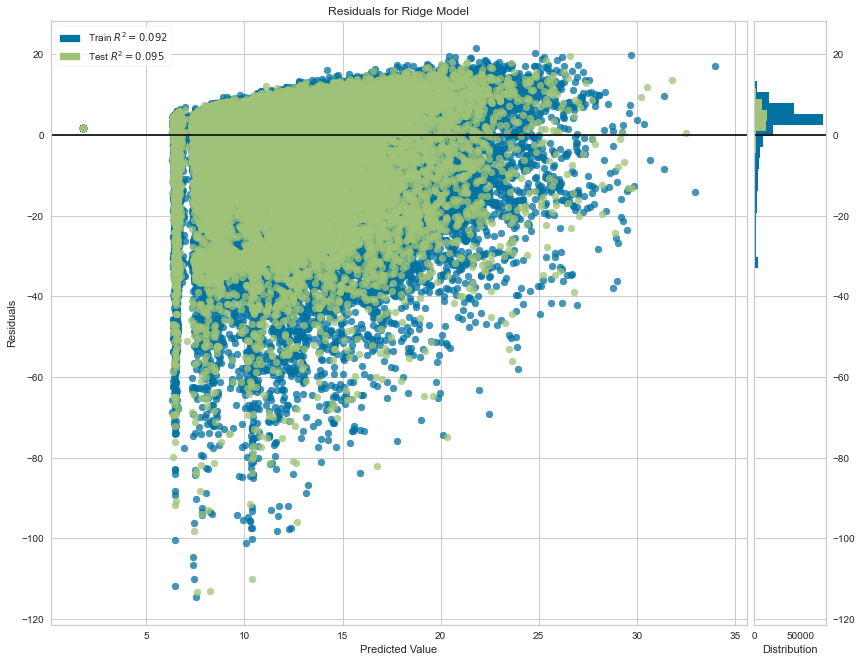

In [37]:
# Using Ridge
for i in cv_list:
  trainer(X_train, X_test, y_train, y_test, "ridge", i)

RMSE: 11.128
R^2: 0.058
RMSE: 11.126
R^2: 0.058
RMSE: 10.951
R^2: 0.088
RMSE: 10.906
R^2: 0.095
RMSE: 10.905
R^2: 0.095
RMSE: 10.905
R^2: 0.095


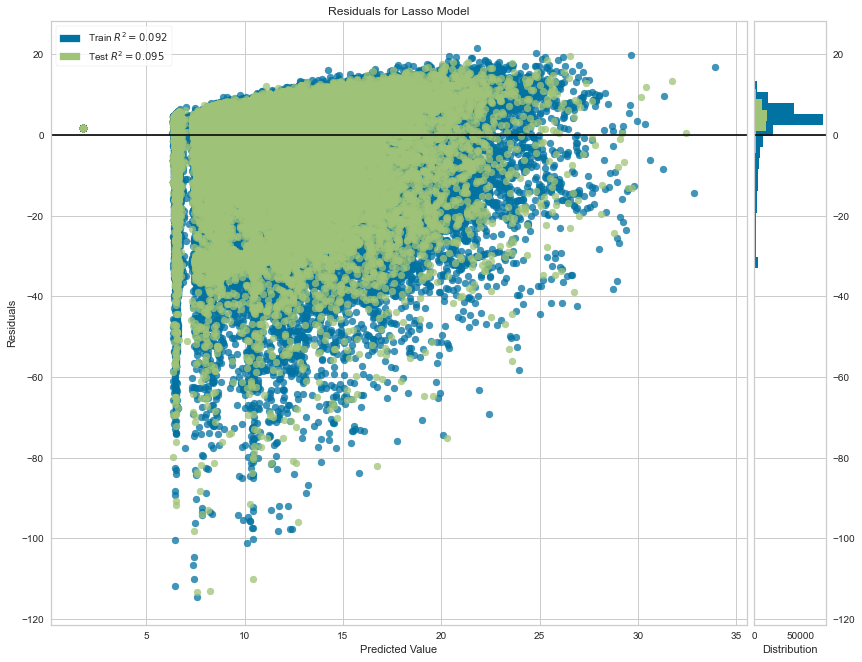

In [38]:
# Using Lasso
for i in cv_list:
  trainer(X_train, X_test, y_train, y_test, "lasso", i)